# This Notebook is for the purpose of Data Acquisition for Lane Scheel's Research

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import pandas as pd
import random as rand
import json
import gwosc
import pycbc
import time

/home/lscheel/.venv/lib/python3.12/site-packages/pycbc/types/array.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal as _lal


## First we will play around with PyCBC, and attempt to generate some things.

This waveform was generated in 0.050 seconds!


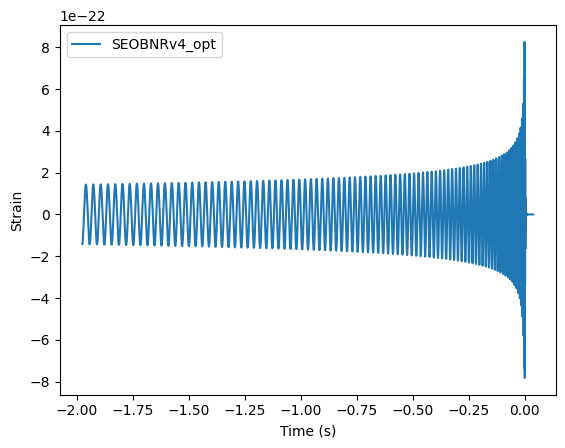

In [2]:
# Let's try to generate and plot a custom time-domain waveform.
from pycbc.waveform import td_approximants
from pycbc.waveform import get_td_waveform

# This will list all available approximants we can use to generate our waveforms
'''
print(td_approximants())
'''

# Timing how long it takes to generate a waveform
start = time.time()

# Let's generate a waveform using just one approximant
hp, hc = get_td_waveform(approximant='SEOBNRv4_opt',  # We will use the SEOBNRv4 approximant
                            mass1=10,                 # Mass of primary BH is 10 solar masses
                            mass2=10,                 # Mass of secondary BH is 10 solar masses
                            delta_t=1.0/4096,         # Sampling rate of our generated waveform
                            f_lower=30,               # Lower frequency bound
                            distance=250,             # Distance in megaparsecs
                            inclination=0.5)          # Inclination in radians, 0=face-on
stop = time.time()
print(f"This waveform was generated in {(stop-start):0.3f} seconds!")

# Let's plot that waveform
plt.plot(hp.sample_times, hp, label='SEOBNRv4_opt')
plt.ylabel("Strain")
plt.xlabel("Time (s)")
plt.legend()
plt.show()

This noise was generated in 0.165 seconds!


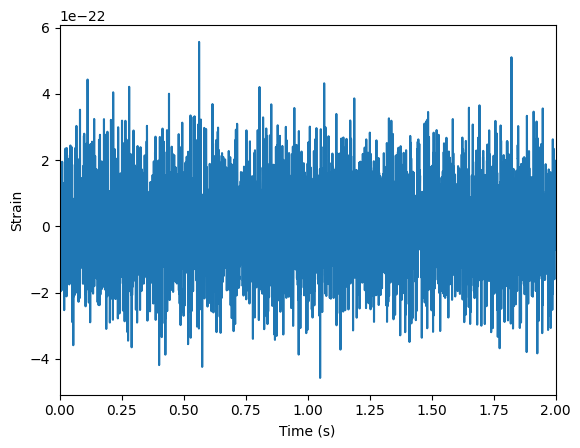

In [5]:
# Let's try to generate some detector noise of the same length as the above waveform.
import pycbc.noise
import pycbc.psd
import pycbc.filter

start = time.time()
# Generate some noise with an advanced ligo power spectral density (psd)
flow = 5.0
delta_f = 1.0 / 16
flen = int(2048 / delta_f) + 1
psd = pycbc.psd.aLIGOZeroDetHighPower(flen, delta_f, flow)

# Generate 1 seconds of noise at 4096 Hz
delta_t = 1 / 4096
tsamples = int(2.013427734375 / delta_t) + 1
ts_original = pycbc.noise.noise_from_psd(tsamples, delta_t, psd)
#plt.plot(ts_original.sample_times, ts_original, label='Original')

# Suppress the low frequencies below 30 Hz
ts = pycbc.filter.highpass(ts_original, 30.0)
#plt.plot(ts.sample_times, ts, label='Highpassed')

# Suppress the high frequencies
ts = pycbc.filter.lowpass_fir(ts, 1000.0, 8)
plt.plot(ts.sample_times, ts, label='Highpassed + Lowpassed')

stop = time.time()
print(f"This noise was generated in {(stop-start):0.3f} seconds!")

# Plot the good stuff
#plt.legend()
plt.xlim(0,2)
plt.ylabel('Strain')
plt.xlabel('Time (s)')
plt.show()

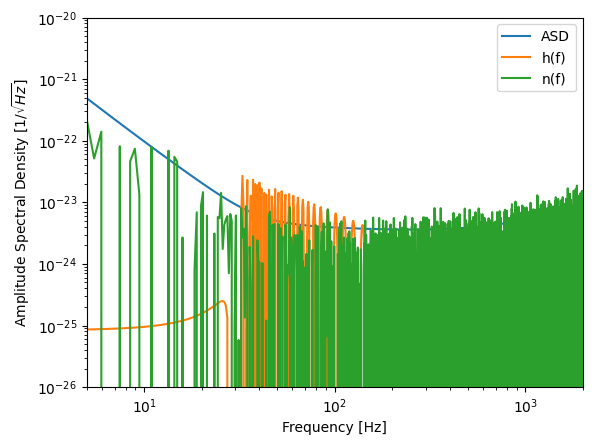

In [4]:
# Let's try to plot the ASD, signal, and noise together.
asd = np.sqrt(psd)

hf = hp.to_frequencyseries()
fs = ts_original.to_frequencyseries()

plt.loglog(asd.sample_frequencies, asd, label='ASD')
plt.loglog(hf.sample_frequencies, hf.real(), label='h(f)')
plt.loglog(fs.sample_frequencies, fs.real(), label='n(f)')
plt.xlim(5,2000)
plt.ylim(1e-26,1e-20)
plt.xlabel("Frequency [Hz]")
plt.ylabel(r"Amplitude Spectral Density [$1 / \sqrt{Hz}$]")
plt.legend()
plt.show()

This waveform was generated in 0.137 seconds!
Producing a dataset of size 10^5, would take approximately 3.793 hours.


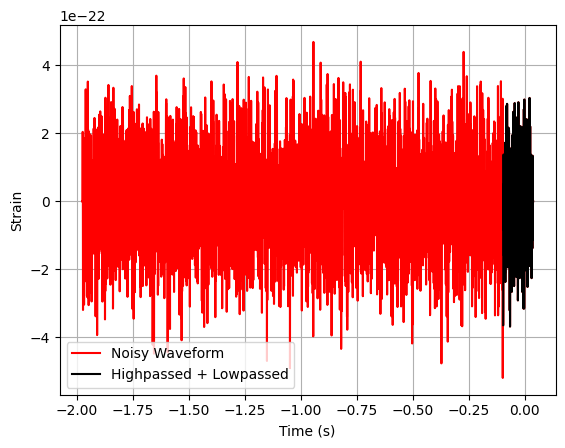

In [5]:
# Now let's try to generate a waveform buried within noise
# Timing how long it takes to generate a waveform
start = time.time()

# Let's generate a waveform using just one approximant
hp, hc = get_td_waveform(approximant='SEOBNRv4_opt',  # We will use the SEOBNRv4 approximant
                            mass1=10,                 # Mass of primary BH is 10 solar masses
                            mass2=10,                 # Mass of secondary BH is 10 solar masses
                            delta_t=1.0/4096,         # Sampling rate of our generated waveform
                            f_lower=0.01,                # Lower frequency bound
                            distance=1000,              # Distance in megaparsecs
                            inclination=0.5)          # Inclination in radians, 0=face-on

# Generate some noise with an advanced ligo power spectral density (psd)
flow = 5.0
delta_f = 0.49660523763336567
flen = int(2048 / delta_f) + 1
psd = pycbc.psd.aLIGOZeroDetHighPower(flen, delta_f, flow)

# Generate 1 seconds of noise at 4096 Hz
delta_t = 1 / 4096
tsamples = int((hp.sample_times[-1]-hp.sample_times[0]) / delta_t) + 1
ts_original = pycbc.noise.noise_from_psd(tsamples, delta_t, psd)

# Transform the time-series into the frequency domain
hf = hp.to_frequencyseries()
fs = ts_original.to_frequencyseries()

# Sum the signal and noise
wf_tot = hf + fs

# Take the summed signal and noise back into the time domain
wf_tot = wf_tot.to_timeseries()

# Suppress the low frequencies below 30 Hz
wf_tot = pycbc.filter.highpass(wf_tot, 30.0)

# Suppress the high frequencies
wf_tot = pycbc.filter.lowpass_fir(wf_tot, 1000.0, 8)

# Stop and report the timing
stop = time.time()
print(f"This waveform was generated in {(stop-start):0.3f} seconds!")
print(f"Producing a dataset of size 10^5, would take approximately {(stop-start)*100000/3600:0.3f} hours.")

# Plot the waveform
plt.plot(wf_tot.sample_times, wf_tot, c='r', label='Noisy Waveform')
plt.plot(wf_tot.sample_times[7700:], wf_tot[7700:], c='k', label='Highpassed + Lowpassed')
plt.legend()
plt.grid(True)
plt.ylabel('Strain')
plt.xlabel('Time (s)')
plt.show()

In [6]:
# Now let's calculate the SNR of this signal
from pycbc.filter import matched_filter

# Calculate the SNR
snr = matched_filter(hp, wf_tot, psd=psd, low_frequency_cutoff=30)

# The peak SNR
peak_snr = max(abs(snr))
print(f"Peak SNR: {peak_snr:.2f}")

Peak SNR: 13.97


In [7]:
# We are now finally able to generate a small batch of data, store it, and time the process.

# meta_parameters
approx = 'SEOBNRv4_opt'
dt = 1.0/4096
f_low = 30

# Let's time the process
start = time.time()

# Sampled parameters
m1 = np.random.uniform(5, 101)
m2 = np.random.uniform(5, 101)
inc = np.random.uniform(0, np.pi)
dist = np.random.randint(500, 4001)

# Generate waveform
hp, hc = get_td_waveform(approximant = approx,
                            mass1 = m1,
                            mass2 = m2,
                            delta_t = dt,
                            f_lower = f_low,
                            distance = dist,
                            inclination = inc)

from pycbc.types import TimeSeries

def test_waveform(**args):
    flow = args['f_lower'] # Required parameter
    dt = args['delta_t']   # Required parameter
    fpeak = args['fpeak']  # A new parameter for my model
    t = np.arange(hp.sample_times[-1]+dt, hp.sample_times[-1]+8, dt)
    f = t/t.max() * (fpeak - flow) + flow
    a = t
    wf = 0 * t
    wf = TimeSeries(wf, delta_t=dt, epoch=hp.end_time+dt)
    return wf.real(), wf.imag()

pycbc.waveform.add_custom_waveform('test', test_waveform, 'time', force=True)

hp2, hc2 = pycbc.waveform.get_td_waveform(approximant="test",
                                        f_lower=30, fpeak=1000,
                                        delta_t=1.0/4096)

# Concatenate the two waveforms (hp1 and hp2)
hp_combined_data = np.concatenate((hp.numpy(), hp2.numpy()))  # Combine the waveform data
hp_combined = pycbc.types.TimeSeries(hp_combined_data, delta_t=dt, epoch=hp.start_time)  # Set the epoch to the start of hp1
hc_combined_data = np.concatenate((hc.numpy(), hc2.numpy()))  # Combine the cross-polarized data
hc_combined = pycbc.types.TimeSeries(hc_combined_data, delta_t=dt, epoch=hp.start_time)

# Concatenate the waveforms to a uniform length
hp_combined = hp_combined[:27500]
hc_combined = hc_combined[:27500]

# Combine hp and hc based on the inclination
combined_waveform = hp_combined * (1 + np.cos(inc)**2) / 2 + hc_combined * np.cos(inc)

# Generate some noise with an advanced ligo power spectral density (psd)# Number of samples in the time series
num_samples = int((combined_waveform.sample_times[-1]-combined_waveform.sample_times[0]) / dt)+1
psd = pycbc.psd.aLIGOZeroDetHighPower(num_samples // 2 + 1, delta_f = 1.0 / float(combined_waveform.end_time-combined_waveform.start_time), low_freq_cutoff=f_low)

# Generate seconds of noise at 4096 Hz
ts = pycbc.noise.noise_from_psd(num_samples, dt, psd)

# Transform the time-series into the frequency domain
hf = combined_waveform.to_frequencyseries()
fs = ts.to_frequencyseries()

# Sum the signal and noise
wf_tot = hf + fs

# Take the summed signal and noise back into the time domain
wf_tot = wf_tot.to_timeseries()

# Suppress the low frequencies below 30 Hz
wf_tot = pycbc.filter.highpass(wf_tot, 30.0)

# Suppress the high frequencies
wf_tot = pycbc.filter.lowpass_fir(wf_tot, 1000.0, 8)

# Find the max amplitude of the waveform
max_amp = max(abs(wf_tot.max()), abs(wf_tot.min()))

# Normalize the waveform
wf_tot_norm = wf_tot / max_amp

# Calculate Chirp Mass
chirp = ((m1*m2)**(3/5))/((m1+m2)**(1/5))

# Calculate the SNR
snr = matched_filter(combined_waveform, wf_tot, psd=psd, low_frequency_cutoff=30)

# The peak SNR
peak_snr = max(abs(snr))

# Let's organize our data in a nice array and export it to a csv file.
params = {'chirp_mass (sol)': chirp, 'distance (Mpc)': dist, 'inclination (rad)': inc, 'peak_snr': peak_snr}

# Combine waveform and parameters into a single dictionary
data = {**params, 'waveform (normalized)': wf_tot_norm}

# Stop timer
end = time.time()

# Create a DataFrame with the waveform data flattened and stored as lists
dataframe = pd.DataFrame([data])

print(np.size(wf_tot), m1, m2, dist, inc, peak_snr)
print(f'Generating a dataset of 10^5 samples would take a total of {((end-start)*100000)/3600:0.2f} hours')

27500 89.02389929899144 67.38578787490766 1583 0.4634878471712269 52.96796605831599
Generating a dataset of 10^5 samples would take a total of 4.09 hours


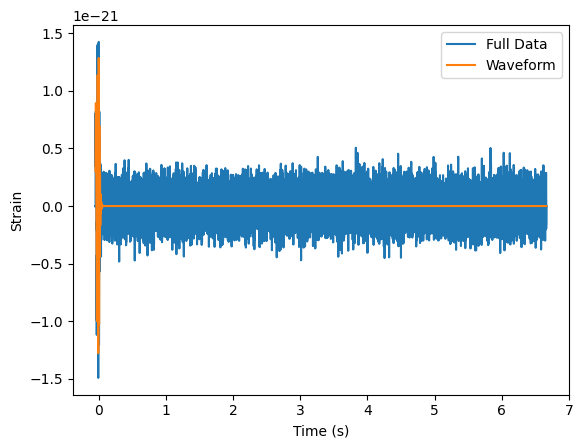

In [8]:
plt.plot(wf_tot.sample_times, wf_tot, label='Full Data')
plt.plot(combined_waveform.sample_times, combined_waveform, label='Waveform')
plt.ylabel("Strain")
plt.xlabel("Time (s)")
plt.legend()
plt.show()

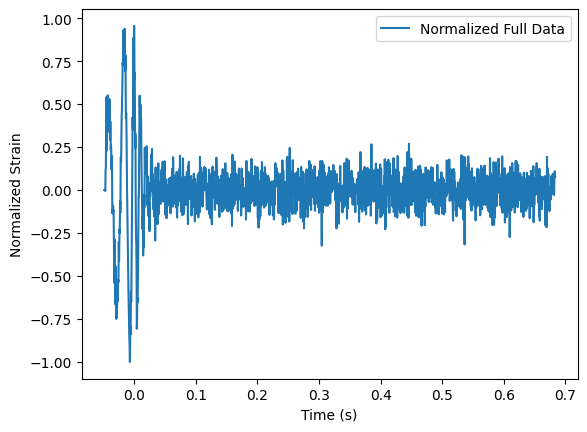

In [9]:
plt.plot(wf_tot.sample_times[:3000], wf_tot_norm[:3000], label='Normalized Full Data')
plt.ylabel("Normalized Strain")
plt.xlabel("Time (s)")
plt.legend()
plt.show()

# Let's now get to generating our full synthetic dataset

In [2]:
from pycbc.waveform import td_approximants
from pycbc.waveform import get_td_waveform
from pycbc.filter import matched_filter
import matplotlib.patheffects as pe
from pycbc.types import TimeSeries
import matplotlib.pyplot as plt
import random as rand
import pandas as pd
import pycbc.filter
import scipy as sp
import numpy as np
import pycbc.noise
import pycbc.psd
import gwosc
import pycbc
import time
import json

In [3]:
num_files = 100
files = np.linspace(1,100,num_files)

for i,file in enumerate(files):

    #Start timer
    start = time.time()
    
    # Define column names
    columns = ['chirp_mass (sol)', 'distance (Mpc)', 'inclination (rad)', 'peak_snr', 'waveform (normalized)', 'waveform_nn (normalized)']
    
    # Create a DataFrame with the waveform data flattened and stored as lists
    dataframe_80 = pd.DataFrame([], columns=columns)
    dataframe_65 = pd.DataFrame([], columns=columns)
    dataframe_50 = pd.DataFrame([], columns=columns)
    dataframe_35 = pd.DataFrame([], columns=columns)
    dataframe_20 = pd.DataFrame([], columns=columns)
    dataframe_05 = pd.DataFrame([], columns=columns)
    dataframe_00 = pd.DataFrame([], columns=columns)
    
    # meta_parameters
    approx = 'SEOBNRv4_opt'
    dt = 1.0/4096
    f_low = 30
    
    num_gen = 100
    
    # Initiate loop
    for _ in range(0,num_gen):
    
        # Sampled parameters
        m1 = np.random.uniform(5, 101)
        m2 = np.random.uniform(5, 101)
        inc = np.random.uniform(0, np.pi)
        dist = np.random.randint(500, 4001)
        
        # Generate waveform
        hp, hc = get_td_waveform(approximant = approx,
                                    mass1 = m1,
                                    mass2 = m2,
                                    delta_t = dt,
                                    f_lower = f_low,
                                    distance = dist,
                                    inclination = inc)
        
        def test_waveform(**args):
            flow = args['f_lower'] # Required parameter
            dt = args['delta_t']   # Required parameter
            fpeak = args['fpeak']  # A new parameter for my model
            t = np.arange(hp.sample_times[-1]+dt, hp.sample_times[-1]+8, dt)
            f = t/t.max() * (fpeak - flow) + flow
            a = t
            wf = 0 * t
            wf = TimeSeries(wf, delta_t=dt, epoch=hp.end_time+dt)
            return wf.real(), wf.imag()
        
        pycbc.waveform.add_custom_waveform('test', test_waveform, 'time', force=True)
        
        hp2, hc2 = pycbc.waveform.get_td_waveform(approximant="test",
                                                f_lower=30, fpeak=1000,
                                                delta_t=1.0/4096)
    
        # Concatenate the two waveforms (hp1 and hp2)
        hp_combined_data = np.concatenate((hp.numpy(), hp2.numpy()))  # Combine the waveform data
        hp_combined = pycbc.types.TimeSeries(hp_combined_data, delta_t=dt, epoch=hp.start_time)  # Set the epoch to the start of hp1
        hc_combined_data = np.concatenate((hc.numpy(), hc2.numpy()))  # Combine the cross-polarized data
        hc_combined = pycbc.types.TimeSeries(hc_combined_data, delta_t=dt, epoch=hp.start_time)
        
        # Concatenate the waveforms to a uniform length
        hp_combined = hp_combined[:27500]
        hc_combined = hc_combined[:27500]
        
        # Combine hp and hc based on the inclination
        combined_waveform = hp_combined * (1 + np.cos(inc)**2) / 2 + hc_combined * np.cos(inc)
        
        # Generate some noise with an advanced ligo power spectral density (psd)# Number of samples in the time series
        num_samples = int((combined_waveform.sample_times[-1]-combined_waveform.sample_times[0]) / dt)+1
        psd = pycbc.psd.aLIGOZeroDetHighPower(num_samples // 2 + 1, delta_f = 1.0 / float(combined_waveform.end_time-combined_waveform.start_time), low_freq_cutoff=f_low)
        
        # Generate seconds of noise at 4096 Hz
        ts = pycbc.noise.noise_from_psd(num_samples, dt, psd)
        
        # Transform the time-series into the frequency domain
        hf = combined_waveform.to_frequencyseries()
        fs = ts.to_frequencyseries()
    
        # Sum the signal and noise
        wf_tot = hf + fs
        
        # Take the summed signal and noise back into the time domain
        wf_tot = wf_tot.to_timeseries()
        
        # Suppress the low frequencies below 30 Hz
        wf_tot = pycbc.filter.highpass(wf_tot, 30.0)
        
        # Suppress the high frequencies
        wf_tot = pycbc.filter.lowpass_fir(wf_tot, 1000.0, 8)
        
        # Find the max amplitude of the waveform
        max_amp = max(abs(wf_tot.max()), abs(wf_tot.min()))
        
        # Normalize the waveform
        wf_tot_norm = wf_tot / max_amp
        wf_norm = combined_waveform / max_amp

        # Save waveforms to JSON strings
        wf_tot_norm = json.dumps(wf_tot_norm.data.tolist())
        wf_norm = json.dumps(wf_norm.data.tolist())
        
        # Calculate Chirp Mass
        chirp = ((m1*m2)**(3/5))/((m1+m2)**(1/5))
        
        # Calculate the SNR
        snr = matched_filter(combined_waveform, wf_tot, psd=psd, low_frequency_cutoff=30)
        
        # The peak SNR
        peak_snr = max(abs(snr))
    
        # Let's organize our data in a nice array and export it to a csv file.
        params = {'chirp_mass (sol)': chirp, 'distance (Mpc)': dist, 'inclination (rad)': inc, 'peak_snr': peak_snr}
        
        # Combine waveform and parameters into a single dictionary
        data = {**params, 'waveform (normalized)': wf_tot_norm, 'waveform_nn (normalized)': wf_norm}

        # Append data to dataframe
        if peak_snr >= 80:
            dataframe_80.loc[len(dataframe_80)] = data
        elif peak_snr >= 65:
            dataframe_65.loc[len(dataframe_65)] = data
        elif peak_snr >= 50:
            dataframe_50.loc[len(dataframe_50)] = data
        elif peak_snr >= 35:
            dataframe_35.loc[len(dataframe_35)] = data
        elif peak_snr >= 20:
            dataframe_20.loc[len(dataframe_20)] = data
        elif peak_snr >= 5:
            dataframe_05.loc[len(dataframe_05)] = data
        else:
            dataframe_00.loc[len(dataframe_00)] = data

    # Save dataframe to csv
    dataframe_00.to_csv('AssortedSNR/SNR_gt_00/Batch'+str(i)+'.csv', index=False, header=True)
    dataframe_05.to_csv('AssortedSNR/SNR_gt_05/Batch'+str(i)+'.csv', index=False, header=True)
    dataframe_20.to_csv('AssortedSNR/SNR_gt_20/Batch'+str(i)+'.csv', index=False, header=True)
    dataframe_35.to_csv('AssortedSNR/SNR_gt_35/Batch'+str(i)+'.csv', index=False, header=True)
    dataframe_50.to_csv('AssortedSNR/SNR_gt_50/Batch'+str(i)+'.csv', index=False, header=True)
    dataframe_65.to_csv('AssortedSNR/SNR_gt_65/Batch'+str(i)+'.csv', index=False, header=True)
    dataframe_80.to_csv('AssortedSNR/SNR_gt_80/Batch'+str(i)+'.csv', index=False, header=True)

    # End timer
    end = time.time()

    # Make Statements
    print(f'Synthetic data generation {(i+1)/num_files*100 :0.2f}% Complete... | '
      f'This batch took {(end-start)/60:0.2f} mins to generate... | '
      f'Estimated time to completion: {(end-start)*(num_files - i)/60:0.2f} mins, or {(end-start)*(num_files - i)/3600:0.2f} hrs...', end=' '*90+'\r')


print('Here is the final batch of synthetic data!')

Here is the final batch of synthetic data!... | This batch took 0.29 mins to generate... | Estimated time to completion: 0.29 mins, or 0.00 hrs...                                                                                          


# Make sure we can load a single stored waveform

<>:15: SyntaxWarning: invalid escape sequence '\o'
<>:15: SyntaxWarning: invalid escape sequence '\o'
/tmp/ipykernel_51050/181526120.py:15: SyntaxWarning: invalid escape sequence '\o'
  plt.text(9500, 0.2, 'Chirp Mass: ' + str(batch.loc[index, 'chirp_mass (sol)'].round(2)) + ' M$_\odot$', fontsize=10, c='w', path_effects=[pe.withStroke(linewidth=1.5, foreground="k")])


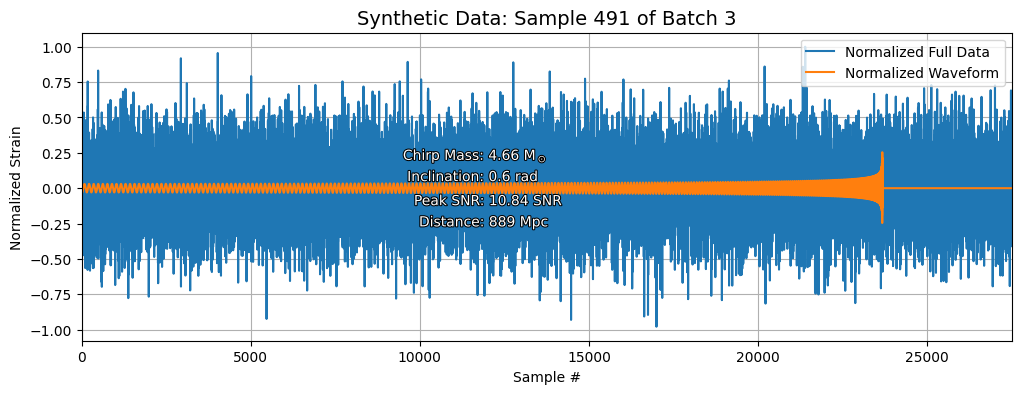

In [39]:
batch_id = 3
index = 491

# Read the csv file
batch = pd.read_csv('SyntheticData/Batch'+str(batch_id)+'.csv')

# Convert JSON string back to lists (waveforms)
waveform_normalized = np.array(json.loads(batch.loc[index, 'waveform (normalized)']))
waveform_nn_normalized = np.array(json.loads(batch.loc[index, 'waveform_nn (normalized)']))

# Plot the data
plt.figure(figsize=(12, 4))
plt.plot(waveform_normalized, label='Normalized Full Data')
plt.plot(waveform_nn_normalized, label='Normalized Waveform')
plt.text(9500, 0.2, 'Chirp Mass: ' + str(batch.loc[index, 'chirp_mass (sol)'].round(2)) + ' M$_\odot$', fontsize=10, c='w', path_effects=[pe.withStroke(linewidth=1.5, foreground="k")])
plt.text(9975, -0.27, 'Distance: ' + str(batch.loc[index, 'distance (Mpc)'].round(2)) + ' Mpc', fontsize=10, c='w', path_effects=[pe.withStroke(linewidth=1.5, foreground="k")])
plt.text(9625, 0.05, 'Inclination: ' + str(batch.loc[index, 'inclination (rad)'].round(2)) + ' rad', fontsize=10, c='w', path_effects=[pe.withStroke(linewidth=1.5, foreground="k")])
plt.text(9825, -0.12, 'Peak SNR: ' + str(batch.loc[index, 'peak_snr'].round(2)) + ' SNR', fontsize=10, c='w', path_effects=[pe.withStroke(linewidth=1.5, foreground="k")])
plt.title(f'Synthetic Data: Sample {index:0.0f} of Batch {batch_id:0.0f}', fontsize=14)
plt.ylabel("Normalized Strain")
plt.xlabel("Sample #")
plt.xlim(0,27500)
plt.legend()
plt.grid()
plt.savefig('(1)_Media/SyntheticData_strain_w_description.png', dpi=150)
plt.show()

# Find the interesting samples

In [29]:
chirp_min = np.argmin(batch.loc[:, 'chirp_mass (sol)'])
chirp_max = np.argmax(batch.loc[:, 'chirp_mass (sol)'])
inc_min = np.argmin(batch.loc[:, 'inclination (rad)'])
inc_max = np.argmax(batch.loc[:, 'inclination (rad)'])
snr_min = np.argmin(batch.loc[:, 'peak_snr'])
snr_max = np.argmax(batch.loc[:, 'peak_snr'])
dist_min = np.argmin(batch.loc[:, 'distance (Mpc)'])
dist_max = np.argmax(batch.loc[:, 'distance (Mpc)'])

print(f'Index of Max Inclination: {inc_max:0.0f}')
print(f'Index of Min Inclination: {inc_min:0.0f}')
print(f'Index of Max Chirp Mass: {chirp_max:0.0f}')
print(f'Index of Min Chirp Mass: {chirp_min:0.0f}')
print(f'Index of Max Distance: {dist_max:0.0f}')
print(f'Index of Min Distance: {dist_min:0.0f}')
print(f'Index of Max SNR: {snr_max:0.0f}')
print(f'Index of Min SNR: {snr_min:0.0f}')

Index of Max Inclination: 593
Index of Min Inclination: 927
Index of Max Chirp Mass: 291
Index of Min Chirp Mass: 491
Index of Max Distance: 916
Index of Min Distance: 398
Index of Max SNR: 153
Index of Min SNR: 260


# Plot a few planes of the parameter space

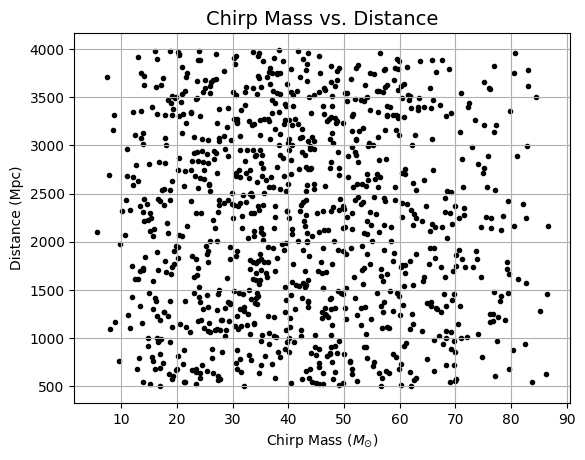

In [42]:
plt.scatter(batch.loc[:, 'chirp_mass (sol)'], batch.loc[:, 'distance (Mpc)'], marker='.', c='k')
plt.title('Chirp Mass vs. Distance', fontsize=14)
plt.xlabel(r'Chirp Mass ($M_{\odot}$)')
plt.ylabel('Distance (Mpc)')
plt.grid()
plt.show()

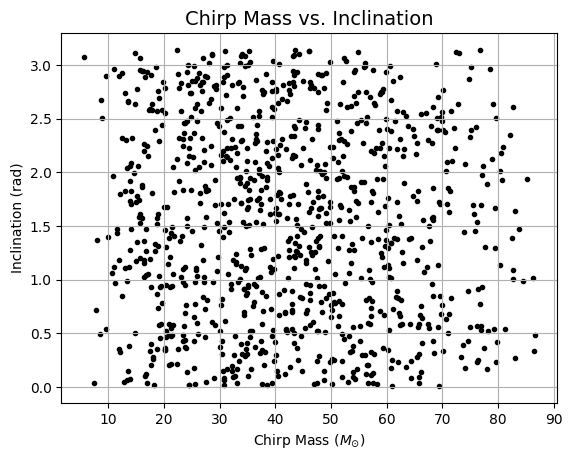

In [44]:
plt.scatter(batch.loc[:, 'chirp_mass (sol)'], batch.loc[:, 'inclination (rad)'], marker='.', c='k')
plt.title('Chirp Mass vs. Inclination', fontsize=14)
plt.xlabel(r'Chirp Mass ($M_{\odot}$)')
plt.ylabel('Inclination (rad)')
plt.grid()
plt.show()

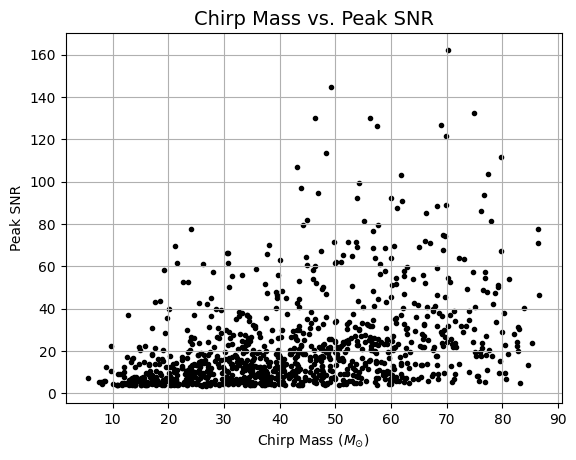

In [45]:
plt.scatter(batch.loc[:, 'chirp_mass (sol)'], batch.loc[:, 'peak_snr'], marker='.', c='k')
plt.title('Chirp Mass vs. Peak SNR', fontsize=14)
plt.xlabel(r'Chirp Mass ($M_{\odot}$)')
plt.ylabel('Peak SNR')
plt.grid()
plt.show()

# Let's check out how SNR varies with each parameters

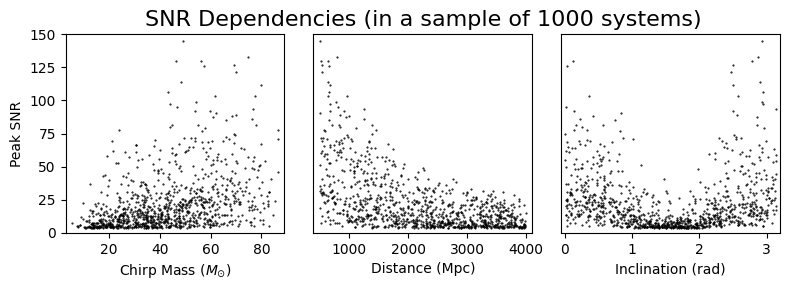

In [62]:
fig, axes = plt.subplots(1,3, figsize=(8,3))

ax0 = axes[0]
ax0.set_ylabel(r'Peak SNR', fontsize=10)
ax0.set_xlabel(r'Chirp Mass ($M_{\odot}$)')
ax0.set_xlim(3,89)
ax0.set_ylim(0,150)
cm_v_snr = ax0.scatter(batch.loc[:, 'chirp_mass (sol)'], batch.loc[:, 'peak_snr'], marker='.', s=1, c='k')

ax1 = axes[1]
ax1.set_title('SNR Dependencies (in a sample of 1000 systems)', fontsize=16)
ax1.set_yticks([])
ax1.set_xlabel(r'Distance (Mpc)')
ax1.set_xlim(400,4100)
ax1.set_ylim(0,150)
dist_v_snr = ax1.scatter(batch.loc[:, 'distance (Mpc)'], batch.loc[:, 'peak_snr'], marker='.', s=1, c='k')

ax2 = axes[2]
ax2.set_yticks([])
ax2.set_xlabel(r'Inclination (rad)')
ax2.set_xlim(-0.05,3.2)
ax2.set_ylim(0,150)
inc_v_snr = ax2.scatter(batch.loc[:, 'inclination (rad)'], batch.loc[:, 'peak_snr'], marker='.', s=1, c='k')


plt.tight_layout()
#plt.savefig('(1)_Media/SNR_Dependencies.png', dpi=150)
plt.show()

# Now that we have synthetic data, let's organize the real data from GWOSC.

In [3]:
import numpy as np
import requests, os
import h5py
import gwpy
import time
import gwosc
import matplotlib.pyplot as plt
import readligo as rl

In [4]:
from gwosc.datasets import event_gps
from gwpy.timeseries import TimeSeries
from gwpy.signal import filter_design
from gwpy.plot import Plot

In [5]:
import gwosc.datasets as gwdata

# Get a list of all events available in the GWOSC catalog
events = gwdata.find_datasets(type="event")

In [9]:
# Define column names
columns = ['chirp_mass (sol)', 'distance (Mpc)', 'inclination (rad)', 'peak_snr', 'waveform (normalized)', 'waveform_event']
    
# Create a DataFrame with the waveform data flattened and stored as lists
dataframe = pd.DataFrame([], columns=columns)

start = 6730
end = -6730

for event in events:
    try:
        gps = event_gps(event)
        data = TimeSeries.fetch_open_data('L1', gps-6, gps+6)
        bp = filter_design.bandpass(50, 250, data.sample_rate)
        notches = [filter_design.notch(line, data.sample_rate) for
                   line in (60, 120, 180)]
        zpk = filter_design.concatenate_zpks(bp, *notches)
        filtered_data = data.filter(zpk, filtfilt=True)
        filtered_data = filtered_data.crop(*filtered_data.span.contract(1))
        max_amp = max(abs(filtered_data.max()), abs(filtered_data.min()))
        norm_data = filtered_data/max_amp
        norm_data = norm_data[start:end]
        norm_wf = norm_data.value
        
        norm_wf = json.dumps(norm_wf.data.tolist())
    
        params = {'chirp_mass (sol)': 0, 'distance (Mpc)': 0, 'inclination (rad)': 0, 'peak_snr': 0}
            
        # Combine waveform and parameters into a single dictionary
        data = {**params, 'waveform (normalized)': norm_wf, 'waveform_event': event}
    
        # Append data to dataframe
        dataframe.loc[len(dataframe)] = data
    except:
        continue

# Save dataframe to csv
dataframe.to_csv('NewRealData/Livingston.csv', index=False, header=True)

In [5]:
h_index = 0
l_index = 0

hanford = pd.read_csv('NewRealData/Hanford.csv')
livingston = pd.read_csv('NewRealData/Livingston.csv')

# Convert JSON string back to lists (waveforms)
h_waveform_normalized = np.array(json.loads(hanford.loc[h_index, 'waveform (normalized)']))
l_waveform_normalized = np.array(json.loads(livingston.loc[l_index, 'waveform (normalized)']))

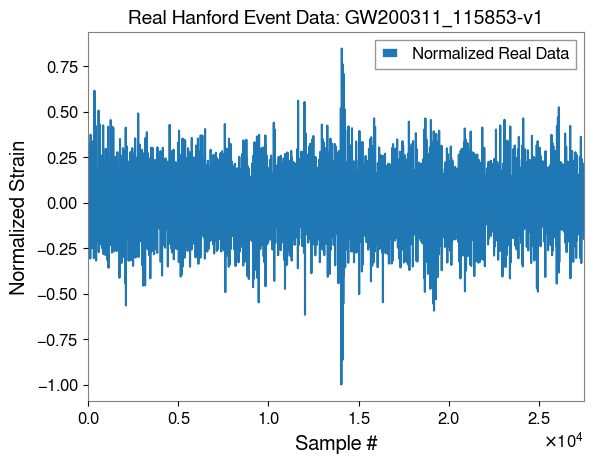

In [34]:
# Plot the data
plt.plot(h_waveform_normalized, label='Normalized Real Data')
plt.title(f'Real Hanford Event Data: {hanford.loc[h_index, 'waveform_event']}', fontsize=14)
plt.ylabel("Normalized Strain")
plt.xlabel("Sample #")
plt.xlim(0,27500)
plt.legend()
plt.grid()
#plt.savefig('(1)_Media/SyntheticData_DecentExample_Cropped.png', dpi=150)
plt.show()

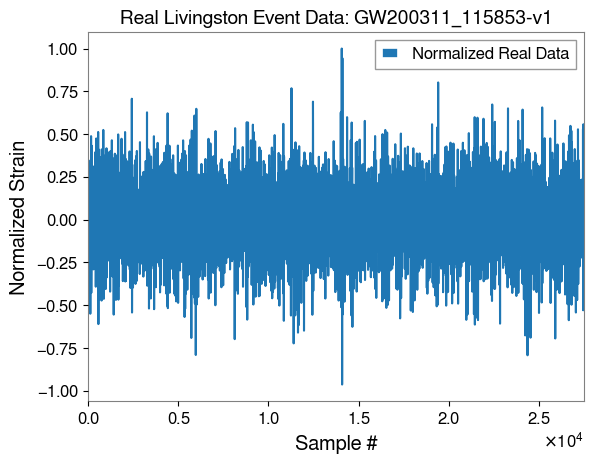

In [35]:
# Plot the data
plt.plot(l_waveform_normalized, label='Normalized Real Data')
plt.title(f'Real Livingston Event Data: {livingston.loc[l_index, 'waveform_event']}', fontsize=14)
plt.ylabel("Normalized Strain")
plt.xlabel("Sample #")
plt.xlim(0,27500)
plt.legend()
plt.grid()
#plt.savefig('(1)_Media/SyntheticData_DecentExample_Cropped.png', dpi=150)
plt.show()

# Now we have a bunch of the real data normalized and in the same form as our synthetic data.

In [361]:
index = 175

cm_livingston = livingston.loc[index, 'chirp_mass (sol)']
dist_livingston = livingston.loc[index, 'distance (Mpc)']
event_livingston = livingston.loc[index, 'waveform_event']

event_livingston, cm_livingston, dist_livingston

('blind_injection-v1', np.float64(0.0), np.int64(0))

In [362]:
d_index = 175
livingston = livingston.drop(d_index)
livingston

,chirp_mass (sol),distance (Mpc),waveform (normalized),waveform_event
14,5.80,570,"[-0.018661656952600532, -0.050043360685189685,...",190924_232654-v1
26,28.60,440,"[0.0031103969534802636, 0.005806957263822444, ...",GW150914-v3
29,15.20,1080,"[0.1387251717070242, 0.15974707713619538, 0.18...",GW151012-v3
31,8.90,450,"[-0.13049101863836504, -0.13813287096972868, -...",GW151226-v2
33,21.40,990,"[0.2656616941465805, 0.27874599302709463, 0.27...",GW170104-v2
...,...,...,...,...
170,34.00,7100,"[0.0016286781068072735, 0.004032627242590083, ...",GW200308_173609-v1
171,26.60,1170,"[0.12980337513570256, 0.03796014558501478, -0....",GW200311_115853-v1
172,8.75,1120,"[-0.01561433363292498, -0.02870950332904604, -...",GW200316_215756-v1
173,15.00,3500,"[-0.25030382248290073, -0.251816836518617, -0....",GW200322_091133-v1


In [360]:
index = 174
livingston.loc[index, 'chirp_mass (sol)'] = 1.94
livingston.loc[index,'distance (Mpc)'] = 201
livingston.loc[index]

chirp_mass (sol)                                                      1.94
distance (Mpc)                                                         201
waveform (normalized)    [0.007882161868535072, 0.08027383287261863, 0....
waveform_event                                          GW230529_181500-v1
Name: 174, dtype: object

In [363]:
livingston.to_csv('NewRealData/Livingston.csv', index=False, header=True)

In [6]:
livingston

,chirp_mass (sol),distance (Mpc),waveform (normalized),waveform_event
0,5.80,570,"[-0.018661656952600532, -0.050043360685189685,...",190924_232654-v1
1,28.60,440,"[0.0031103969534802636, 0.005806957263822444, ...",GW150914-v3
2,15.20,1080,"[0.1387251717070242, 0.15974707713619538, 0.18...",GW151012-v3
3,8.90,450,"[-0.13049101863836504, -0.13813287096972868, -...",GW151226-v2
4,21.40,990,"[0.2656616941465805, 0.27874599302709463, 0.27...",GW170104-v2
...,...,...,...,...
130,34.00,7100,"[0.0016286781068072735, 0.004032627242590083, ...",GW200308_173609-v1
131,26.60,1170,"[0.12980337513570256, 0.03796014558501478, -0....",GW200311_115853-v1
132,8.75,1120,"[-0.01561433363292498, -0.02870950332904604, -...",GW200316_215756-v1
133,15.00,3500,"[-0.25030382248290073, -0.251816836518617, -0....",GW200322_091133-v1
